In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import xgboost as xgb

In [3]:
data=pd.read_csv('drive/MyDrive/output_data2.csv', encoding='utf-8')
data['w']=1
data

,Female,Male,European,Indian,Maori,Other Ethnicities,Pacific Island,Asian,Elderly,Middle-aged-old,Middle-aged-young,Teenagers,class,w
0,1,0,1,0,0,0,0,0,0,0,0,1,0,1
1,1,0,0,0,1,0,0,0,0,0,1,0,0,1
2,0,1,0,0,1,0,0,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,0,0,0,1,0,0,1
4,1,0,0,0,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62781,1,0,0,0,0,0,1,0,0,0,1,0,0,1
62782,1,0,0,0,0,0,1,0,0,0,1,0,0,1
62783,1,0,0,0,0,0,1,0,0,0,1,0,0,1
62784,1,0,0,0,0,0,1,0,0,1,0,0,0,1


In [4]:
def calculate_disparate_impact(data, sensitive_col, label_col):
    # Calculate the total number of favorable and unfavorable groups and the number of positive cases separately
    total_privileged = data[data[sensitive_col] == 1].shape[0]
    total_unprivileged = data.shape[0] - total_privileged
    privileged_positive = data[(data[sensitive_col] == 1) & (data[label_col] == 1)].shape[0]
    unprivileged_positive = data[(data[sensitive_col] != 1) & (data[label_col] == 1)].shape[0]
    # Calculate weights
    w_privileged=data[data[sensitive_col] == 1]['w'].mean()
    w_unprivileged=data[data[sensitive_col] != 1]['w'].mean()
    # Calculate Disparate Impact
    disparate_impact = ((unprivileged_positive / total_unprivileged)*w_unprivileged) / ((privileged_positive / total_privileged)*w_privileged)
    return disparate_impact

select_features =['Asian','Pacific Island','Other Ethnicities','Maori','Indian','European','Male','Female',"Elderly","Middle-aged-old","Middle-aged-young","Teenagers"]
results = []
for feature in select_features:
  disparate_impact = calculate_disparate_impact(data, feature, "class")
  results.append({'Feature': feature, 'Disparate Impact': disparate_impact})
results_DI1 = pd.DataFrame(results)
results_DI1

,Feature,Disparate Impact
0,Asian,1.643961
1,Pacific Island,1.770870
2,Other Ethnicities,2.139506
3,Maori,1.215768
4,Indian,0.823762
5,European,0.651632
6,Male,1.003331
7,Female,0.996681
8,Elderly,0.995850
9,Middle-aged-old,0.926093


In [5]:
def scale(df):
  min_value = 0.8
  midel = 1
  max_value = 1.2

  upmin = df[df['Disparate Impact']>1]['Disparate Impact'].min()
  upmax = df[df['Disparate Impact']>1]['Disparate Impact'].max()
  downmin = upmin = df[df['Disparate Impact']<1]['Disparate Impact'].min()
  downmax = upmin = df[df['Disparate Impact']<1]['Disparate Impact'].max()
  for feature in select_features:
    data = df[df['Feature']==feature]['Disparate Impact'].values[0]
    if(data>1):
      data = (data - upmin) / (upmax - upmin) * (max_value - midel) + midel
    if(data<1):
      data = (data - downmin) / (downmax - downmin) * (midel - min_value) + min_value
    df.loc[df['Feature'] == feature, 'scaled_DI'] = data

scale(results_DI1)
results_DI1['weights']=results_DI1['Disparate Impact'].div(results_DI1['scaled_DI'])
results_DI1

,Feature,Disparate Impact,scaled_DI,weights
0,Asian,1.643961,1.113277,1.476686
1,Pacific Island,1.770870,1.135487,1.559569
2,Other Ethnicities,2.139506,1.200000,1.782921
3,Maori,1.215768,1.038341,1.170875
4,Indian,0.823762,0.899771,0.915524
5,European,0.651632,0.800000,0.814540
6,Male,1.003331,1.001164,1.002164
7,Female,0.996681,1.000000,0.996681
8,Elderly,0.995850,0.999518,0.996330
9,Middle-aged-old,0.926093,0.959085,0.965600


In [6]:
for feature in select_features:
  data.loc[data[feature] == 1,'w'] = data[data[feature] == 1]['w']*results_DI1[results_DI1['Feature'] == feature]['weights'].values[0]

In [7]:
results = []
for feature in select_features:
  disparate_impact = calculate_disparate_impact(data, feature, "class")
  results.append({'Feature': feature, 'Disparate Impact': disparate_impact})
results_DI2 = pd.DataFrame(results)
results_DI2

,Feature,Disparate Impact
0,Asian,1.193884
1,Pacific Island,1.158525
2,Other Ethnicities,1.261257
3,Maori,1.066096
4,Indian,1.013727
5,European,1.026898
6,Male,1.026183
7,Female,0.974485
8,Elderly,1.146535
9,Middle-aged-old,1.012259


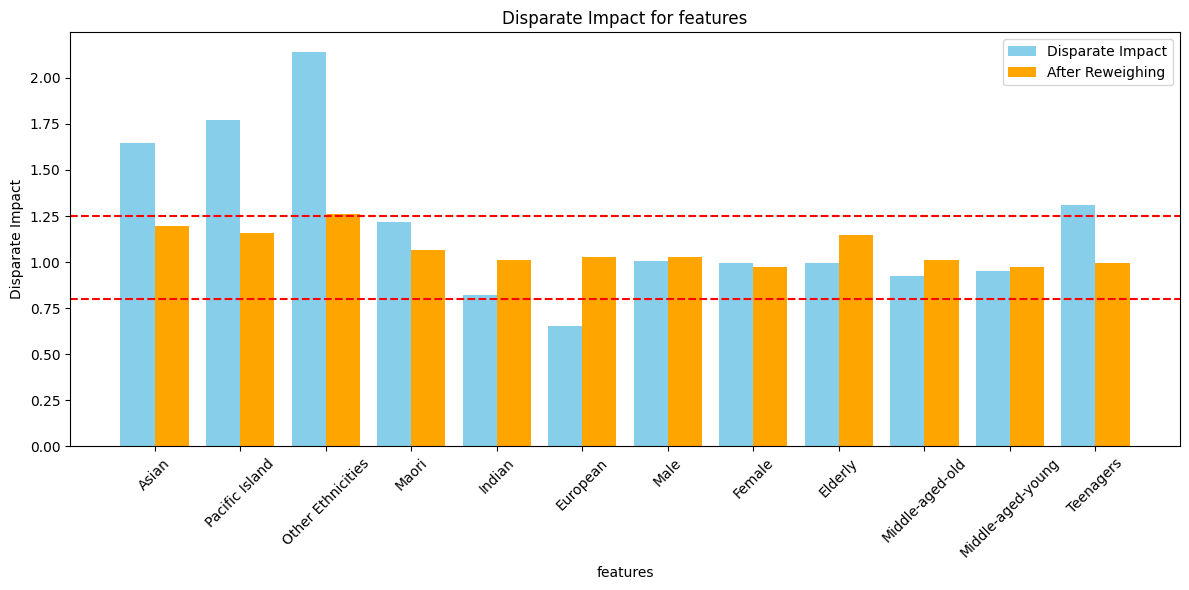

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature names and data values
features = list(results_DI1['Feature'])
disparate_impact = list(results_DI1['Disparate Impact'])
after_reweighing = list(results_DI2['Disparate Impact'])
# Create a histogram
plt.figure(figsize=(12, 6))
bar_width = 0.4

index = np.arange(len(features))
plt.bar(index, disparate_impact, bar_width, label='Disparate Impact', color='skyblue')
plt.bar(index + bar_width, after_reweighing, bar_width, label='After Reweighing', color='orange')

plt.xlabel('features')
plt.ylabel('Disparate Impact')
plt.title('Disparate Impact for features')
plt.xticks(index + bar_width / 2, features, rotation=45)

plt.legend()
plt.axhline(y=0.8, color='red', linestyle='--')
plt.axhline(y=1.25, color='red', linestyle='--')

plt.tight_layout()
plt.legend()
plt.show()